In [14]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [15]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [16]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [17]:
for route in routes:
    add_extra_data(route)

In [18]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [19]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

## Helper Functions

In [20]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [21]:
def weekday_or_weekend(given_day):
    if given_day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        return "weekday"
    else:
        return "weekend"

In [22]:
def pre_lockdown(given_time):
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    
    # lockdown = March 24th 2020
    if month > 3:
        return False
    elif month == 3:
        if day >= 24:
            return False
    
    return True

In [23]:
def train_test_split(data):
    
    # partition data into 4 groups
    group1 = data.iloc[:(int(data.shape[0] / 4))]
    group2 = data.iloc[(int(data.shape[0] / 4)):(int(2 * data.shape[0] / 4))]
    group3 = data.iloc[(int(2 * data.shape[0] / 4)):(int(3 * data.shape[0] / 4))]
    group4 = data.iloc[(int(3 * data.shape[0] / 4)):]
    print(group1.shape, group2.shape, group3.shape, group4.shape)

    # get a random sample of 80% from each group to ensure the train and test
    # have similar features
    training = group1.sample(frac = 0.8)
    training = training.append(group2.sample(frac = 0.8))
    training = training.append(group3.sample(frac = 0.8))
    training = training.append(group4.sample(frac = 0.8))

    # validation is all the remaining data that wasn't chosen for the training set
    validation = data[~data.apply(tuple,1).isin(training.apply(tuple,1))]
    print(training.shape, validation.shape)
    return training, validation

In [24]:
def get_attrs(gap, stop_a, stop_b, a_id):
    start = time.time()
    
    # if gap == 5:
    min_time = 1
    max_time = 15
    
    if (gap > 5) and (gap <= 10):
        min_time = 10
        max_time = 22
    elif (gap > 10) and (gap <= 15):
        min_time = 15
        max_time = 30
    elif (gap > 15) and (gap <= 20):
        min_time = 20
        max_time = 40
    elif (gap > 20) and (gap <= 25):
        min_time = 31
        max_time = 55
    elif (gap > 25) and (gap <= 30):
        min_time = 40
        max_time = 70
    elif (gap > 30):
        min_time = 50
        max_time = 90

    attributes = []
    for i, journey in stop_b.iterrows():

        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        [bus_id, _, date, direction, _] = journey['vehicle_id'].split('_')
        to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'

        for j, match in stop_a.iterrows():
            if match['vehicle_id'].startswith(to_match_id):
                leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                journey_time = arr_dt - leave_dt

                if (journey_time > dt.timedelta(minutes = min_time)) & (journey_time < dt.timedelta(minutes = max_time)):
                    item = []
                    item.append(journey_time)

                    seconds = journey_time.total_seconds()
                    item.append(seconds)

                    d = dt.datetime.strptime(match['time_of_arrival'][:10], '%Y-%m-%d')
                    d = calendar.day_name[d.weekday()]
                    w = weekday_or_weekend(d)
                    item.append(w)

                    t = int(journey['time_of_arrival'][11:13])
                    item.append(t)

                    c = pre_lockdown(journey['time_of_arrival'])
                    item.append(c)
                    
                    item.append(gap)

                    attributes.append(item)
                    break

    print("Getting journey times took {}".format(time.time() - start))
    
    return attributes

## Data Preprocessing

Pick 2 stops on a route. Calculate all the journey times between them. Make a dataset with attributes time of day (split into hour slots), journey time, day of week, pre lockdown.

Choose multiple 2 stops

1) gap of 5: North End Road -> Phillimore Gardens route 9

2) gap of 10: Willesden Bus Garage -> Harrow Road / Kilburn Lane route 52

3) gap of 15: Willesden Bus Garage -> Chesterton Road route 52

4) gap of 20: Willesden Bus Garage -> Notting Hill Gate Station route 52

5) gap of 25: Willesden Bus Garage -> Palace Gate route 52

6) gap of 30: Willesden Bus Garage -> Knightsbridge Station  / Harrods route 52

7) gap of 35: Willesden Bus Garage -> Victoria Bus Station route 52

8) gap of 2: Nigel Road -> East Dulwich Road / Peckham Rye route 37

9) gap of 8: Townley Road -> Chaucer Road / Effra Parade route 37

10) gap of 12: North Dulwich Station -> Solon Road route 37

11) gap of 16: North Dulwich Station -> Long Road / Clapham Common route 37

12) gap of 28: Hammersmith Bus Station -> Charing Cross Stn / Trafalgar Square route 9

In [25]:
stop_as = ["North End Road"] + ["Willesden Bus Garage" for i in range(0, 6)] + ["Nigel Road", "Townley Road", "North Dulwich Station", "North Dulwich Station", "Hammersmith Bus Station"]
stop_bs = ["Phillimore Gardens", "Harrow Road / Kilburn Lane", "Chesterton Road", "Notting Hill Gate Station", "Palace Gate", "Knightsbridge Station  / Harrods", "Victoria Bus Station", "East Dulwich Road / Peckham Rye", "Chaucer Road / Effra Parade", "Solon Road", "Long Road / Clapham Common", "Charing Cross Stn / Trafalgar Square"]
route_ids = ["9"] + ["52" for i in range(0, 6)] + ["37", "37", "37", "37", "9"]

print(len(stop_as))
print(len(stop_bs))
print(len(route_ids))

12
12
12


In [ ]:
all_attrs = []

for i, a in enumerate(stop_as):
    bus = data.get(route_ids[i])
    stop_a_data = bus.loc[(bus['bus_stop_name'] == a) & (bus['direction'] == 'inbound')]
    [_, a_id, _, _, _] = stop_a_data.iloc[0]['vehicle_id'].split('_')
    
    stop_b_data = bus.loc[(bus['bus_stop_name'] == stop_bs[i]) & (bus['direction'] == 'inbound')]
    
    print("{} to {}".format(a, stop_bs[i]))
    attrs = get_attrs((i + 1) * 5, stop_a_data, stop_b_data, a_id)
    all_attrs.append(attrs)

North End Road to Phillimore Gardens


In [522]:
#append all the data together

flattened = [item for sublist in all_attrs for item in sublist]
print(len(flattened))
df = pd.DataFrame(flattened, columns = ['Journey Time', 'Journey Time (s)', 'Day of Week', 'Time of Day', 'Pre Lockdown', 'Gap'])
df.head()

2931


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap
0,00:09:32,572.0,weekday,10,True,5
1,00:10:43,643.0,weekday,10,True,5
2,00:09:37,577.0,weekday,10,True,5
3,00:08:20,500.0,weekday,10,True,5
4,00:06:05,365.0,weekday,11,True,5


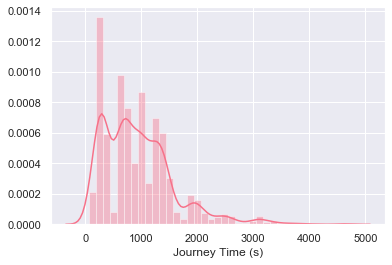

In [523]:
sns.distplot(df['Journey Time (s)'])

In [524]:
# Get rid of outliers from dataset
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

outlier_indexes = detect_outlier_z_score(df['Journey Time (s)'])
print("Outlier indexes: ", outlier_indexes)
df = df.drop(outlier_indexes)

Outlier indexes:  [2716, 2823, 2825, 2828, 2838, 2841, 2844, 2868, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895, 2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906, 2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930]


In [525]:
df.describe()

,Journey Time,Journey Time (s),Time of Day,Gap
count,2875,2875.000000,2875.000000,2875.000000
mean,0 days 00:14:58.643130,898.643130,12.400000,12.864348
std,0 days 00:09:11.129705,551.129705,4.067113,6.756195
min,0 days 00:01:08,68.000000,2.000000,5.000000
25%,0 days 00:06:06.500000,366.500000,9.000000,5.000000
50%,0 days 00:13:09,789.000000,12.000000,10.000000
75%,0 days 00:21:01,1261.000000,15.000000,20.000000
max,0 days 00:47:49,2869.000000,23.000000,30.000000


In [526]:
dow_encoder = preprocessing.LabelEncoder()
ld_encoder = preprocessing.LabelEncoder()

dow_encoder.fit(df['Day of Week'])
encoded = dow_encoder.transform(df['Day of Week'])
df['Day of Week Encoded'] = encoded
days_of_week_label = list(dow_encoder.inverse_transform([0,1]))
print(list(zip([0,1], days_of_week_label)))
encoded = ld_encoder.fit_transform(df['Pre Lockdown'])
df['Pre Lockdown Encoded'] = encoded
pre_lockdown_label = list(ld_encoder.inverse_transform([0, 1]))
print(list(zip([0, 1], pre_lockdown_label)))

[(0, 'weekday'), (1, 'weekend')]
[(0, False), (1, True)]


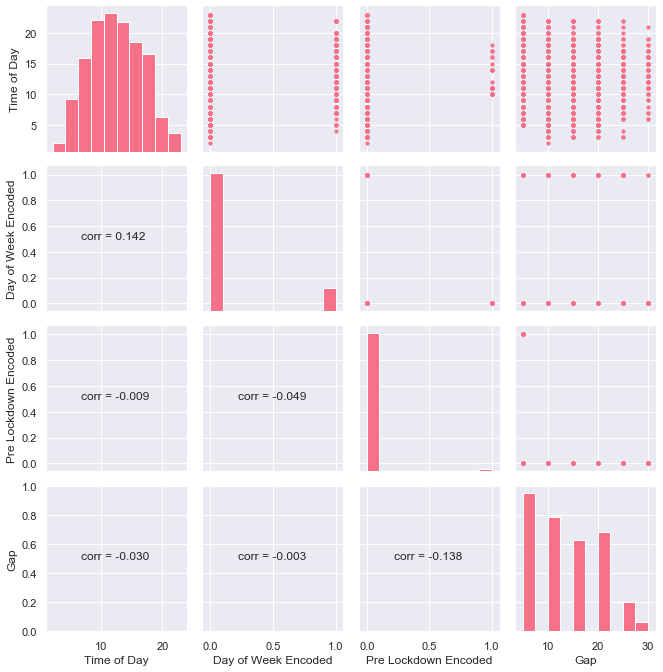

In [527]:
from scipy.stats import pearsonr

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("corr = {:.3f}".format(r),
                xy=(.25, .5), xycoords=ax.transAxes)
    
pp = sns.PairGrid(df[['Time of Day', 'Day of Week Encoded', 'Pre Lockdown Encoded', 'Gap']], height = 2.3, diag_sharey=False)
pp.map_upper(plt.scatter, s=10)
pp.map_diag(plt.hist)
pp.map_lower(corrfunc)

#### Feature correlation

The above pairplot indicates that the features are not related to each other, i.e. they are independent of each other. This means that they can be used together in multivariate regression. This is supported by the Pearson Correlation Coefficients calculated for the three variables. The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score. The coefficient returns a value between -1 and 1 that represents the limits of correlation from a full negative correlation to a full positive correlation. A value of 0 means no correlation. The value must be interpreted, where often a value below -0.5 or above 0.5 indicates a notable correlation, and values between those values suggests a less notable correlation.

#### Feature information

There is a lot more data that was collected post lockdown compared to pre lockdown (as can be seen by the bottom right graph that has a taller 0 = False bar).
There is data for post lockdown for weekdays and weekends, but for pre lockdown there is only weekday data.
For post lockdown data there is data for all times of day that the bus runs, but for pre lockdown there is only data for between 1000 to approximately 1800.

From the middle graph, it can be seen that there is a lot more data collected on weekdays compared to weekends.
It can also be seen from the top middle graph that on weekends, there are gaps during the day where data has not been collected. For example, there is no data after approximately 1800.

From the top left graph, it can be seen that the data trend is 2 humps (perhaps morning peak and evening peak).

## Linear Regression

Regression models are generally outperformed by other types of models, but they reveal which independent variable is less/more important for predicting travel times.

Try regression models with one of the variables^2, or also do separate regression models for 1) peak weekdays vs 2) nonpeak weekdays and then 3) weekends?

#### Measures of success:

- **r2 score**, also known as coefficient of determination. Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.
- **Root Mean Square Error** (rmse). Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The smaller the better
- **Explained variance regression score** function: Best possible score is 1.0, lower values are worse. https://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score 
- **Mean Absolute Percentage Error** (MAPE): Worst is 100, lower values are better. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

When standardized observations and forecasts are used as RMSE inputs, there is a direct relationship with the correlation coefficient. For example, if the correlation coefficient is 1, the RMSE will be 0, because all of the points lie on the regression line (and therefore there are no errors).

## Single predictor variable

### Predict journey time based on gap size between stops

$j = b_0 + b_1g$

$j = b_0 + b_1g + b_2g^2$

$j = b_0 + b_1g + b_2g^2 + b_3g^3$

where 
- $j$ is the predicted journey time
- $d$ is the gap size between the 2 stops

Wouldn't expect there to be a peak, but an increasing gradient so that the larger the gap the greater the predicted journey time.

#### Splitting the data into training and test sets.

Need to ensure that the train and test sets are similar.

In [533]:
# partition data into 4 groups sorted by gap
df_gap = df.sort_values("Gap")
training_gap, validation_gap = train_test_split(df_gap)
training_gap.head()

(718, 8) (719, 8) (719, 8) (719, 8)
(2299, 8) (426, 8)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Day of Week Encoded,Pre Lockdown Encoded
552,00:05:39,339.0,weekday,10,False,5,0,0
138,00:03:29,209.0,weekday,19,False,5,0,0
715,00:04:56,296.0,weekday,21,False,5,0,0
776,00:04:38,278.0,weekday,18,False,5,0,0
781,00:03:59,239.0,weekday,20,False,5,0,0


In [536]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_gap(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_gap['Gap'][:, np.newaxis])

    x_train = poly.transform(training_gap['Gap'][:, np.newaxis])
    x_test = poly.transform(validation_gap['Gap'][:, np.newaxis])
    y_train = training_gap['Journey Time (s)'][:, np.newaxis]
    y_test = validation_gap['Journey Time (s)'][:, np.newaxis]

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_gaps = []
rmse_gaps = []
mape_gaps = []
y_test_gap = []
model_gaps = []

for i in range(1, 15):
    y_test_gap, y_pred_gap, rmse_gap, mape_gap, model_gap = poly_regression_gap(i)

    y_pred_gaps.append(y_pred_gap)
    rmse_gaps.append(rmse_gap)
    mape_gaps.append(mape_gap)
    model_gaps.append(model_gap)

Slope/Coefficients:  [[ 0.         79.18667583]]
Intercept:  [-121.644253]
The root mean squared error is:  151.38397656224512
The coefficient of determination is:  0.9352666460115754
Slope/Coefficients:  [[ 0.         49.23513594  1.04115459]]
Intercept:  [43.5279046]
The root mean squared error is:  141.0304892702087
The coefficient of determination is:  0.9438183724441561
Slope/Coefficients:  [[ 0.00000000e+00  1.35663062e+02 -5.22970802e+00  1.31215792e-01]]
Intercept:  [-272.80286656]
The root mean squared error is:  141.84555650869996
The coefficient of determination is:  0.9431671072017256
Slope/Coefficients:  [[ 0.00000000e+00  3.20189745e+02 -2.62017619e+01  1.06279211e+00
  -1.40414372e-02]]
Intercept:  [-785.47396452]
The root mean squared error is:  138.03845312749638
The coefficient of determination is:  0.946176930837698
Slope/Coefficients:  [[ 0.00000000e+00 -3.16969008e+02  6.94599442e+01 -5.41607326e+00
   1.88066012e-01 -2.35692890e-03]]
Intercept:  [701.60981441]
The

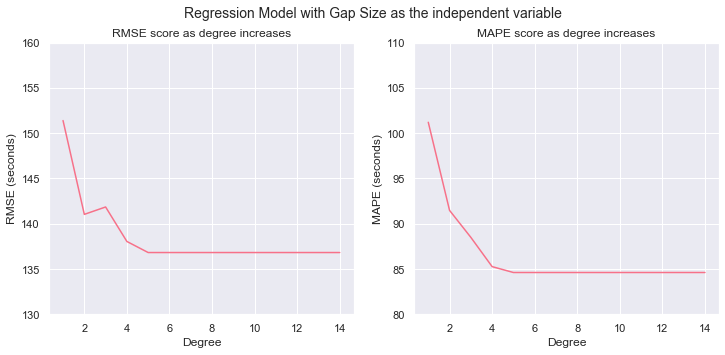

In [539]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_gaps) + 1)], rmse_gaps)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(130,160)

ax[1].plot([i for i in range(1, len(mape_gaps) + 1)], mape_gaps)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(80,110)

fig.suptitle("Regression Model with Gap Size as the independent variable", fontsize=14)
plt.show()

In [540]:
best_rmse_gap = min(rmse_gaps)
best_mape_gap = min(mape_gaps)
best_rmse_gap_index = rmse_gaps.index(best_rmse_gap)
best_mape_gap_index = mape_gaps.index(best_mape_gap)
print(best_rmse_gap_index, best_mape_gap_index)

13 13


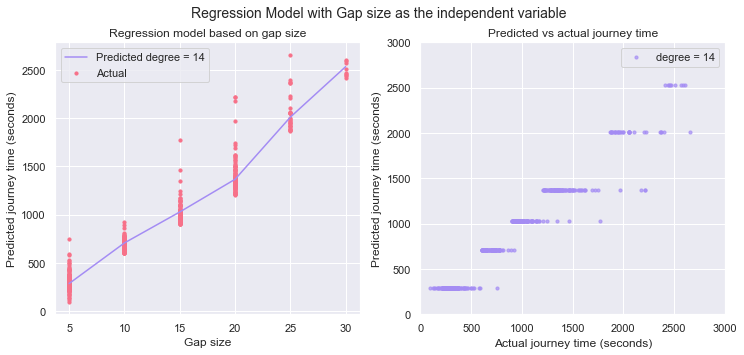

In [544]:
import operator

x = validation_gap['Gap'][:, np.newaxis]
sort_axis = operator.itemgetter(0)
sorted_zip_mape = sorted(zip(x, y_pred_gaps[best_mape_gap_index]), key=sort_axis)
x_mape, y_pred_mape = zip(*sorted_zip_mape)
sorted_zip_rmse = sorted(zip(x, y_pred_gaps[best_rmse_gap_index]), key=sort_axis)
x_rmse, y_pred_rmse = zip(*sorted_zip_rmse)

# Plot outputs
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
ax[0].scatter(x, y_test_gap, label = "Actual", s = 10)
ax[0].plot(x_rmse, y_pred_rmse, label = "Predicted degree = {}".format(best_rmse_gap_index + 1), color = cs[6])
if best_rmse_gap_index != best_mape_gap_index:
    ax[0].plot(x_mape, y_pred_mape, label = "Predicted degree = {}".format(best_mape_gap_index + 1), color = cs[3])
ax[0].set_title("Regression model based on gap size")
ax[0].set_xlabel("Gap size")
ax[0].set_ylabel("Predicted journey time (seconds)")
ax[0].legend()

ax[1].scatter(y_test_gap, y_pred_rmse, label = "degree = {}".format(best_rmse_gap_index + 1), color = cs[6], alpha = 0.7, s = 10)
if best_rmse_gap_index != best_mape_gap_index:
    ax[1].scatter(y_test_gap, y_pred_mape, label = "degree = {}".format(best_mape_gap_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax[1].set_title("Predicted vs actual journey time")
ax[1].set_xlabel("Actual journey time (seconds)")
ax[1].set_ylabel("Predicted journey time (seconds)")
ax[1].set_xlim(0, 3000)
ax[1].set_ylim(0, 3000)
ax[1].legend()

fig.suptitle("Regression Model with Gap size as the independent variable", fontsize=14)
plt.show()

## Multiple predictor variables == Multiple Linear Regression

### Day of Week and Gap

$j = b_0 + b_1d + b_2g$

$j = b_0 + b_1d^2 + b_2dg + b_3g^2$

$j = b_0 + b_1d^3 + b_2d^2g + b_3dg^2 + b_4g^3$

where 
- $j$ is the predicted journey time
- $d$ is the day of week
- $t$ is the time of day

In [545]:
# partition data into 4 groups
df_dow_gap = df.sort_values(["Gap", "Day of Week"])
training_dow_gap, validation_dow_gap = train_test_split(df_dow_gap)
training_dow_gap.head()

(718, 8) (719, 8) (719, 8) (719, 8)
(2299, 8) (416, 8)


,Journey Time,Journey Time (s),Day of Week,Time of Day,Pre Lockdown,Gap,Day of Week Encoded,Pre Lockdown Encoded
553,00:05:09,309.0,weekday,10,False,5,0,0
483,00:03:47,227.0,weekday,20,False,5,0,0
178,00:04:58,298.0,weekday,10,False,5,0,0
9,00:07:50,470.0,weekday,11,True,5,0,1
30,00:06:13,373.0,weekday,10,True,5,0,1


In [552]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_dow_gap[['Day of Week Encoded', 'Gap']])

    x_train = poly.transform(training_dow_gap[['Day of Week Encoded', 'Gap']])
    x_test = poly.transform(validation_dow_gap[['Day of Week Encoded', 'Gap']])
    y_train = training_dow_gap['Journey Time (s)'][:, np.newaxis]
    y_test = validation_dow_gap['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_dow_gap = []
rmse_dow_gap = []
mape_dow_gap = []
y_test_dow_gap = []
model_dow_gap = []

for i in range(1, 15):
    y_test_dow_gap, y_pred_mult, rmse_mult, mape_mult, model_mult = poly_regression_mult(i)
    y_pred_dow_gap.append(y_pred_mult)
    rmse_dow_gap.append(rmse_mult)
    mape_dow_gap.append(mape_mult)
    model_dow_gap.append(model_mult)

Slope/Coefficients:  [[  0.         -14.41971511 531.78687676]]
Intercept:  [895.09743367]
The root mean squared error is:  144.16173088680088
The coefficient of determination is:  0.9446678404982413
Slope/Coefficients:  [[  0.           4.11312262 341.35096846   4.11312262 -20.41941556
  198.8309452 ]]
Intercept:  [895.09743367]
The root mean squared error is:  131.50348383729028
The coefficient of determination is:  0.9539582140991051
Slope/Coefficients:  [[ 0.00000000e+00  6.73536845e-01  8.87269620e+02  6.73536845e-01
  -9.57969821e+00 -9.71710843e+02  6.73536845e-01 -9.57969821e+00
   5.18100528e+00  6.51801970e+02]]
Intercept:  [895.09743367]
The root mean squared error is:  127.66209990386461
The coefficient of determination is:  0.9566088049096854
Slope/Coefficients:  [[ 0.00000000e+00 -5.25429234e-01  2.08737662e+03 -5.25429234e-01
  -4.55887795e+00 -4.98772844e+03 -5.25429234e-01 -4.55887795e+00
   2.98452331e+00  5.38483902e+03 -5.25429234e-01 -4.55887795e+00
   2.98452331e+

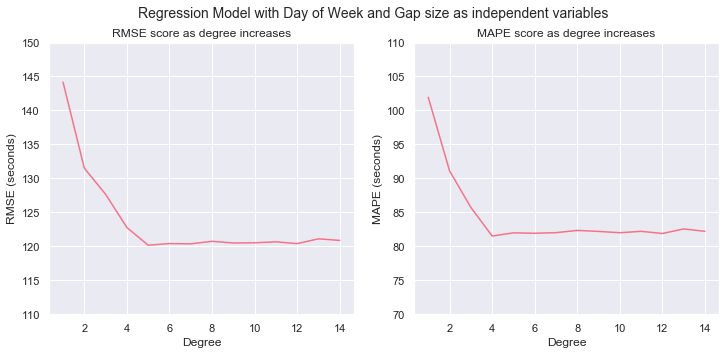

In [553]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_dow_gap) + 1)], rmse_dow_gap)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
ax[0].set_ylim(110, 150)

ax[1].plot([i for i in range(1, len(mape_dow_gap) + 1)], mape_dow_gap)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
ax[1].set_ylim(70, 110)

fig.suptitle("Regression Model with Day of Week and Gap size as independent variables", fontsize=14)
plt.show()

In [554]:
best_rmse_dow_gap = min(rmse_dow_gap)
best_mape_dow_gap = min(mape_dow_gap)
best_rmse_dow_gap_index = rmse_dow_gap.index(best_rmse_dow_gap)
best_mape_dow_gap_index = mape_dow_gap.index(best_mape_dow_gap)
print(best_rmse_dow_gap_index, best_mape_dow_gap_index)

4 3


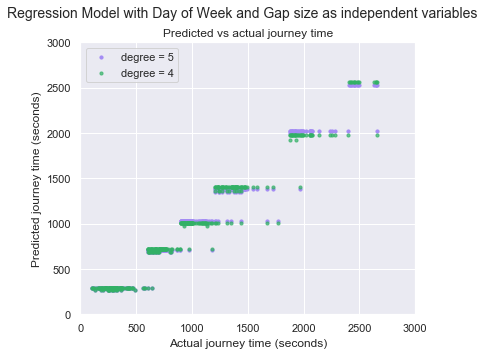

In [557]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test_dow_gap, y_pred_dow_gap[best_rmse_dow_gap_index], label = "degree = {}".format(best_rmse_dow_gap_index + 1), color = cs[6], s = 10)
if best_rmse_dow_gap_index != best_mape_dow_gap_index:
    ax.scatter(y_test_dow_gap, y_pred_dow_gap[best_mape_dow_gap_index], label = "degree = {}".format(best_mape_dow_gap_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
ax.set_xlim(0, 3000)
ax.set_ylim(0, 3000)
ax.legend()

fig.suptitle("Regression Model with Day of Week and Gap size as independent variables", fontsize=14)
plt.show()

### Time of Day and Gap

In [ ]:
# partition data into 4 groups
df_tod_gap = df.sort_values(["Gap", "Time of Day"])
training_tod_gap, validation_tod_gap = train_test_split(df_tod_gap)
training_tod_gap.head()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult2(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_tod_gap[['Time of Day', 'Gap']])

    x_train = poly.transform(training_tod_gap[['Time of Day', 'Gap']])
    x_test = poly.transform(validation_tod_gap[['Time of Day', 'Gap']])
    y_train = training_tod_gap['Journey Time (s)'][:, np.newaxis]
    y_test = validation_tod_gap['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_tod_gap = []
rmse_tod_gap = []
mape_tod_gap = []
y_test_tod_gap = []
model_tod_gap = []

for i in range(1, 15):
    y_test_tod_gap, y_pred_mult2, rmse_mult2, mape_mult2, model_mult2 = poly_regression_mult2(i)
    
    y_pred_tod_gap.append(y_pred_mult2)
    rmse_tod_gap.append(rmse_mult2)
    mape_tod_gap.append(mape_mult2)
    model_tod_gap.append(model_mult2)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_tod_gap) + 1)], rmse_tod_gap)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
# ax[0].set_ylim(65, 90)

ax[1].plot([i for i in range(1, len(mape_tod_gap) + 1)], mape_tod_gap)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
# ax[1].set_ylim(50, 70)

fig.suptitle("Regression Model with Time of Day and Gap size as independent variables", fontsize=14)
plt.show()

In [395]:
best_rmse_tod_gap = min(rmse_tod_gap)
best_mape_tod_gap = min(mape_tod_gap)
best_rmse_tod_gap_index = rmse_tod_gap.index(best_rmse_tod_gap)
best_mape_tod_gap_index = mape_tod_gap.index(best_mape_tod_gap)
print(best_rmse_tod_gap_index, best_mape_tod_gap_index)

1 1


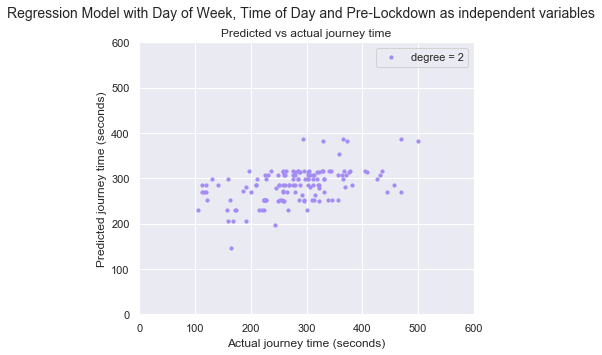

In [396]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test_tod_gap, y_pred_tod_gap[best_rmse_tod_gap_index], label = "degree = {}".format(best_rmse_tod_gap_index + 1), color = cs[6], alpha = 0.7, s = 10)
if best_rmse_tod_gap_index != best_mape_tod_gap_index:
    ax.scatter(y_test_tod_gap, y_pred_tod_gap[best_mape_tod_gap_index], label = "degree = {}".format(best_mape_tod_gap_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
# ax.set_xlim(0, 600)
# ax.set_ylim(0, 600)
ax.legend()

fig.suptitle("Regression Model with Time of Day and Gap size as independent variables", fontsize=14)
plt.show()

### Time of Day, Day of Week and Gap

In [ ]:
# partition data into 4 groups
df_tod_dow_gap = df.sort_values(["Gap", "Time of Day", "Day of Week"])
training_tod_dow_gap, validation_tod_dow_gap = train_test_split(df_tod_dow_gap)
training_tod_dow_gap.head()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

def poly_regression_mult3(degree):
    poly = PolynomialFeatures(degree = degree)
    poly.fit(training_tod_dow_gap[['Time of Day', 'Day of Week Encoded', 'Gap']])

    x_train = poly.transform(training_tod_dow_gap[['Time of Day', 'Day of Week Encoded', 'Gap']])
    x_test = poly.transform(validation_tod_dow_gap[['Time of Day', 'Day of Week Encoded', 'Gap']])
    y_train = training_tod_dow_gap['Journey Time (s)'][:, np.newaxis]
    y_test = validation_tod_dow_gap['Journey Time (s)'][:, np.newaxis]
    
    # Scale the data
    scaler = preprocessing.StandardScaler()
    scaler = scaler.fit(x_train)
    x_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Fit model
    linreg = LinearRegression()
    linreg.fit(x_scaled, y_train)

    # Apply the model to the validation data to predict the ‘Journey Time’
    y_pred = linreg.predict(x_test_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_error(y_test, y_pred)

    # coefficient of determination = 1 is perfect prediction
    print('The coefficient of determination is: ', r2)
    
    return y_test, y_pred, rmse, mape, linreg

y_pred_tod_dow_gap = []
rmse_tod_dow_gap = []
mape_tod_dow_gap = []
y_test_tod_dow_gap = []
model_tod_dow_gap = []

for i in range(1, 15):
    y_test_tod_dow_gap, y_pred_mult3, rmse_mult3, mape_mult3, model_mult3 = poly_regression_mult3(i)
    
    y_pred_tod_dow_gap.append(y_pred_mult3)
    rmse_tod_dow_gap.append(rmse_mult3)
    mape_tod_dow_gap.append(mape_mult3)
    model_tod_dow_gap.append(model_mult3)

In [ ]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].plot([i for i in range(1, len(rmse_tod_dow_gap) + 1)], rmse_tod_dow_gap)
ax[0].set_title("RMSE score as degree increases")
ax[0].set_xlabel("Degree")
ax[0].set_ylabel("RMSE (seconds)")
# ax[0].set_ylim(65, 90)

ax[1].plot([i for i in range(1, len(mape_tod_dow_gap) + 1)], mape_tod_dow_gap)
ax[1].set_title("MAPE score as degree increases")
ax[1].set_xlabel("Degree")
ax[1].set_ylabel("MAPE (seconds)")
# ax[1].set_ylim(50, 70)

fig.suptitle("Regression Model with Time of Day, Day of Week and Gap size as independent variables", fontsize=14)
plt.show()

In [ ]:
best_rmse_tod_dow_gap = min(rmse_tod_dow_gap)
best_mape_tod_dow_gap = min(mape_tod_dow_gap)
best_rmse_tod_dow_gap_index = rmse_tod_dow_gap.index(best_rmse_tod_dow_gap)
best_mape_tod_dow_gap_index = mape_tod_dow_gap.index(best_mape_tod_dow_gap)
print(best_rmse_tod_dow_gap_index, best_mape_tod_dow_gap_index)

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y_test_tod_dow_gap, y_pred_tod_dow_gap[best_rmse_tod_dow_gap_index], label = "degree = {}".format(best_rmse_tod_dow_gap_index + 1), color = cs[6], alpha = 0.7, s = 10)
if best_rmse_tod_dow_gap_index != best_mape_tod_dow_gap_index:
    ax.scatter(y_test_tod_dow_gap, y_pred_tod_dow_gap[best_mape_tod_dow_gap_index], label = "degree = {}".format(best_mape_tod_dow_gap_index + 1), color = cs[3], alpha = 0.7, s = 10)
ax.set_title("Predicted vs actual journey time")
ax.set_xlabel("Actual journey time (seconds)")
ax.set_ylabel("Predicted journey time (seconds)")
# ax.set_xlim(0, 600)
# ax.set_ylim(0, 600)
ax.legend()

fig.suptitle("Regression Model with Time of Day, Day of Week and Gap size as independent variables", fontsize=14)
plt.show()

## Compare the models

In [429]:
compare_mapes = [best_mape_tod, best_mape_dow, best_mape_mult, best_mape_mult2]
compare_rmses = [best_rmse_tod, best_rmse_dow, best_rmse_mult, best_rmse_mult2]
compare_mapes_indices = [best_mape_tod_index, best_mape_dow_index, best_mape_mult_index, best_mape_mult2_index]
compare_rmses_indices = [best_rmse_tod_index, best_rmse_dow_index, best_rmse_mult_index, best_rmse_mult2_index]
compare_mapes_degree = [x + 1 for x in compare_mapes_indices]
compare_rmses_degree = [x + 1 for x in compare_rmses_indices]

compare_labels = ["Time of day", "Day of week", "ToD + DoW", "ToD + DoW + Lockdown"]
best_mapes_zipped = list(zip(compare_mapes, compare_mapes_degree, compare_labels))
best_rmses_zipped = list(zip(compare_rmses, compare_rmses_degree, compare_labels))
print(best_mapes_zipped)
print(best_rmses_zipped)

[(58.44862981476179, 2, 'Time of day'), (65.70403661826637, 14, 'Day of week'), (56.08190548407646, 13, 'ToD + DoW'), (52.665604711352856, 2, 'ToD + DoW + Lockdown')]
[(77.7857208969304, 8, 'Time of day'), (83.93109179527758, 5, 'Day of week'), (75.97719359157101, 14, 'ToD + DoW'), (69.79338376930846, 2, 'ToD + DoW + Lockdown')]


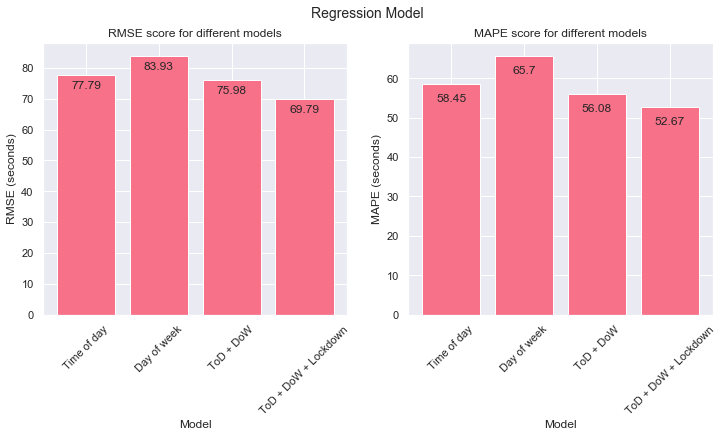

In [432]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)
plt.xticks(rotation=45)

ax[0].bar(compare_labels, compare_rmses)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("RMSE (seconds)")

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)

rects_rmse = ax[0].patches
labels_rmse = [round(best_rmse_tod, 2), round(best_rmse_dow, 2), round(best_rmse_mult, 2), round(best_rmse_mult2, 2)]

for rect, label in zip(rects_rmse, labels_rmse):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(compare_labels, compare_mapes)
ax[1].set_title("MAPE score for different models")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mape = [round(best_mape_tod, 2), round(best_mape_dow, 2), round(best_mape_mult, 2), round(best_mape_mult2, 2)]

for rect, label in zip(rects_mape, labels_mape):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Regression Model', fontsize=14)
plt.show()

According to both MAPE and RMSE, the best model is the one that has time of day and day of week as independent variables in the multilinear regression model with degree 3 and 7 respectively

TODO: In this case, is MAPE or RMSE a better measure of success?

The above values change depending on the split of training and testing -> might be necessary to do k-fold cross validation and get the average MAPE and average RMSE? Can email Peter to discuss

In [400]:
regression_mapes = compare_mapes
regression_rmses = compare_rmses

%store regression_mapes regression_rmses

Stored 'regression_mapes' (list)
Stored 'regression_rmses' (list)


## Testing out best model with random gaps and random routes

Test the best 2 models

In [442]:
best_model1, best_model2 = sorted(best_mapes_zipped, key = lambda t: t[0])[:2]
print(best_model1)
print(best_model2)

all_models = {
    "ToD": model_tods,
    "DoW": model_dows,
    "ToD + DoW": model_mults,
    "ToD + DoW + Lockdown": model_mults2
}

model1_degree = best_model1[1]
model1 = all_models.get(best_model1[2])[model1_degree - 1]

model2_degree = best_model2[1]
model2 = all_models.get(best_model2[2])[model2_degree - 1]

(52.665604711352856, 2, 'ToD + DoW + Lockdown')
(56.08190548407646, 13, 'ToD + DoW')


### Gaps from size 5 to 35

### 1st best model

In [451]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

mapes_gap = []
rmses_gap = []

for i, b in enumerate(stop_bs):
    print("Gap = {}".format((i + 1) * 5))
    res = get_attrs((i + 1) * 5, stop_a, b, a_id)
    
    df_gap = res.sort_values(["Time of Day", "Day of Week", "Pre Lockdown"])
    poly1 = PolynomialFeatures(degree = model1_degree)

    x_test_gap = poly1.fit_transform(df_gap[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
    y_test_gap = df_gap['Journey Time (s)'][:, np.newaxis]

    # Scale the data
    scaler = StandardScaler()
    x_gap_scaled = scaler.fit_transform(x_test_gap)

    # Predict. Model is already trained.
    y_pred_gap = model1.predict(x_gap_scaled)

    # Calculate measures of success
    mse = mean_squared_error(y_test_gap, y_pred_gap)
    rmse = np.sqrt(mse)
    mape = mean_absolute_error(y_test_gap, y_pred_gap)
    mapes_gap.append(mape)
    rmses_gap.append(rmse)

    print(rmse, mape)

Gap = 5
Getting journey times took 188.26101207733154
107.50956930583848 87.10300523726522
Gap = 10
Getting journey times took 145.89141297340393
426.18650653927955 417.3202777283249
Gap = 15
Getting journey times took 156.50052905082703
750.5426924568935 740.2400395274673
Gap = 20
Getting journey times took 279.50642585754395
1092.831596199362 1084.1104976928148
Gap = 25
Getting journey times took 280.73078203201294
1745.8211195725478 1735.7619872505543
Gap = 30
Getting journey times took 221.38657784461975
2352.4959361700076 2332.565597954367
Gap = 35
Getting journey times took 226.06498289108276


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

Ok so the regression models not generalising well to larger gaps makes sense because the model that I am using learnt model which has only learnt on gaps of 5 so it will only ever predict stuff for like between 10 mins or so. So what I need to do, is give it a different training set -> the training set needs to include gap_size as a learnable parameter and this needs to be part of the training process.

In [455]:
test = get_attrs((i + 1) * 5, stop_a, stop_bs[1], a_id)
    
df_gap = test.sort_values(["Time of Day", "Day of Week", "Pre Lockdown"])
poly1 = PolynomialFeatures(degree = model1_degree)

x_test_gap = poly1.fit_transform(df_gap[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
y_test_gap = df_gap['Journey Time (s)'][:, np.newaxis]

# Scale the data
scaler = StandardScaler()
x_gap_scaled = scaler.fit_transform(x_test_gap)

# Predict. Model is already trained.
y_pred_gap = model1.predict(x_gap_scaled)

# Calculate measures of success
mse = mean_squared_error(y_test_gap, y_pred_gap)
rmse = np.sqrt(mse)
mape = mean_absolute_error(y_test_gap, y_pred_gap)
print(mse, rmse, mape)

Getting journey times took 174.98966097831726
120887.03343646442 347.68812668318776 336.8264353036169


In [457]:
print(y_pred_gap[:10])

[[135.19140399]
 [135.19140399]
 [135.19140399]
 [ 80.69140399]
 [ 80.69140399]
 [ 80.69140399]
 [166.82299705]
 [166.82299705]
 [166.82299705]
 [166.82299705]]


In [ ]:
poly = PolynomialFeatures(degree = degree)
poly.fit(training_mult2[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])

x_train = poly.transform(tr[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
x_test = poly.transform(va[['Day of Week Encoded', 'Time of Day', 'Pre Lockdown Encoded']])
y_train = tr['Journey Time (s)'][:, np.newaxis]
y_test = va['Journey Time (s)'][:, np.newaxis]

# Scale the data
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(x_train)
x_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Fit model
linreg = LinearRegression()
linreg.fit(x_scaled, y_train)

# Apply the model to the validation data to predict the ‘Journey Time’
y_pred = linreg.predict(x_test_scaled)

# Calculate measures of success
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_error(y_test, y_pred)